# Game Music dataset: genre classification

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from ast import literal_eval
import os
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

df = pd.read_csv('midi_dataframe.csv', parse_dates=[11])
# Cleaning
df.drop_duplicates(subset='file_name', inplace=True)
df.dropna(subset=['tgdb_genres'], inplace=True)
categories_filter = df.console.isin(['Medleys', 'Piano Only'])
remix_filter = df.title.str.contains('[Rr]emix')

df = df[~categories_filter & ~remix_filter]
df_stripped = df.copy()
df_stripped.title = df.title.str.replace('\(\d+\)', '').str.rstrip()
df_stripped['rank'] = df.title.str.extract('\((\d+)\)', expand=False)
df = df_stripped.sort_values(by='rank', ascending=False).groupby(['brand', 'console', 'game', 'title']).first().reset_index()
df.set_index('file_name', inplace=True)

In [3]:
num_games = len(df.groupby(['tgdb_platform', 'tgdb_gametitle']))
print('There is %d midi files, from %d games, with %d midis matched with tgdb'
      %(len(df),
        num_games,
        (df.tgdb_gametitle.notnull().sum())))
df_features = pd.read_csv('features.csv').set_index('file_name')
print("There is %d midi files with computed features"%(len(df_features)))

print("After removing not valid midi files, we have %d files"%(len(df.join(df_features, how='inner'))))

There is 22179 midi files, from 3243 games, with 22179 midis matched with tgdb
There is 31483 midi files with computed features
After removing not valid midi files, we have 22005 files


In [4]:
#df = pd.read_csv('midi_dataframe_cleaned.csv', parse_dates=[11])
#df.set_index('file_name', inplace=True)
df_genres = df.tgdb_genres.map(literal_eval, 'ignore').apply(pd.Series).stack().reset_index(level=1, drop=True).reset_index().set_index('file_name')
df_genres.columns = ['genre']

# Problem statement

By joining the game music dataframe with the features dataset produced by JSimbolic, the final dataset to be used for the classification task is obtained.

This dataset provides 156 musical feature for each valid midi. 

In [5]:
df_pred = df_genres.join(df_features, how='inner').reset_index()
df_pred = df_pred.replace([np.inf, -np.inf], np.nan).dropna()
df_pred.head()

,file_name,genre,Prevalence_of_Most_Common_Pitch,Prevalence_of_Most_Common_Pitch_Class,Relative_Prevalence_of_Top_Pitches,Relative_Prevalence_of_Top_Pitch_Classes,Interval_Between_Most_Prevalent_Pitches,Interval_Between_Most_Prevalent_Pitch_Classes,Number_of_Common_Pitches,Pitch_Variety,...,Parallel_Motion,Similar_Motion,Contrary_Motion,Oblique_Motion,Parallel_Fifths,Parallel_Octaves,Dynamic_Range,Variation_of_Dynamics,Variation_of_Dynamics_In_Each_Voice,Average_Note_to_Note_Change_in_Dynamics
0,0004cc74bde3bc82f44afb5f566187c3dbcea9b2.mid,Platform,0.1593,0.2242,0.7222,0.7500,5.0,5.0,2.0,28.0,...,0.0000,0.0,0.0000,0.00000,0.0,0.0,63.0,17.65,6.3240,13.7800
1,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Action,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128
2,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Adventure,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128
3,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Sports,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128
4,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Strategy,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128


To simplify this first analysis, only the five categories which are more represented in the dataset will be considered for this analysis. These are Action, Role-Playing, Platform, Adventure, and Shooter.

In [6]:
df_pred = df_pred[(df_pred['genre'] == 'Action') | (df_pred['genre'] == 'Role-Playing') | (df_pred['genre'] == 'Platform') | (df_pred['genre'] == 'Adventure') | (df_pred['genre'] == 'Shooter')]
print("For this first analysis, 5 genres entailing " + str(df_pred.shape[0]) + " MIDIs will be considered.")

For this first analysis, 5 genres entailing 27010 MIDIs will be considered.


The dataset is divided into features and labels - X and y respectively - for the purpose of the classification task. The labels Y are mapped to integers to comply with the requirements of certain Machine Learning models such as linear regression.

In [8]:
X = df_pred.iloc[:, 2:]
y, y_string = pd.factorize(df_pred['genre'])

The dataset is split into training and testing sets with a 8-2 ratio, which seems very reasonable considering the size of the dataset.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=42)
print(str(X_train.shape[0]) + " MIDIs are used for training, " + str(X_test.shape[0]) + " are used for testing.")

21608 MIDIs are used for training, 5402 are used for testing.


# Models Evaluation

In this section various Machine Learning classification models are used with the goal of identifying the one who best fits the task. The models take as input the whole set of features and perform the classification task.

As a first approach, a simple linear classifier is used.

In [9]:
lrc = LinearRegression()
lrc.fit(X_train, y_train)
score = lrc.score(X_test, y_test)
print("the Linear Regression classifier yields a score of " + str(score))

the Linear Regression classifier yields a score of 0.04334847397196817


Since this linear model performs poorly for the given task, the more robust Random Forest and AdaBoost classifier (with decision trees as weak learners) are used. The parameters are chosen in order to make full use of the model without overloading it.

In [10]:
rfc = RandomForestClassifier(n_estimators=100, max_features = None, max_depth = 10, random_state = 1)
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
print("The Random Forest classifier yields a score of " + str(score))

The Random Forest classifier yields a score of 0.299333580155498


In [12]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
score = abc.score(X_test, y_test)
print("The Ada Boost classifier yields a score of " + str(score))

The Ada Boost classifier yields a score of 0.3493150684931507


Event though the accuracy of the classification improved drastically by using these powerful ensemble methods, the result is still disappointing.

The bad performance of the previous models could be a sign that the data is not linearly separable. It is therefore worth trying to use a kernel. 

A kernelized Support Vectore Machine (SVM) model using the rbf kernel is therefore used. 

In [13]:
clf = SVC(kernel = 'rbf', gamma=1)
clf.fit(X_train, y_train) 
score = clf.score(X_test, y_test)
print("The kernelized SVC classifier yields a score of " + str(score))

The kernelized SVC classifier yields a score of 0.14124398370973715


The drop in performance compared to the ensemble methods make us think that the problem lies not in the models but in the features themselves.

Let's try applying PCA to the features to see what happens.

In [17]:
pca = PCA(n_components=3)
pca.fit(X)
pca.explained_variance_ratio_

array([0.74252231, 0.12781416, 0.0402669 ])

The answer is very informative: the 1st principal component accounts for 75% of the variance in the dataset and the three first components account for 90%. This intuitevely means that the information relevant for the classification task tends to be centered towards determinate features, as opposed to being spread evenly in the dataset.

The next step is trying to identify these relevant features.

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(solver='lbfgs', multi_class="multinomial", penalty="l2")
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
clf.score(X_test, y_test)

0.37370418363569047


0.35690485005553496

In [14]:
best_features = np.take(df_pred.columns[2:], np.abs(clf.coef_).argsort()[:,-10:])
for i in range(len(y_string)):
    print("For class %s, best features:"%y_string[i])
    for feature in best_features[i]:
        print("  -", feature)

For class Platform, best features:
  - Average_Rest_Fraction_Per_Voice
  - Partial_Chords
  - Variability_of_Note_Durations
  - Amount_of_Arpeggiation
  - String_Ensemble_Prevalence
  - Note_Density
  - Rhythmic_Variability
  - Average_Number_of_Simultaneous_Pitch_Classes
  - Voice_Equality_-_Note_Duration
  - Variability_Across_Voices_of_Total_Rests_Per_Voice
For class Action, best features:
  - Number_of_Relatively_Strong_Rhythmic_Pulses
  - Repeated_Notes
  - Standard_Triads
  - Amount_of_Arpeggiation
  - Variability_Across_Voices_of_Total_Rests_Per_Voice
  - Note_Density
  - Number_of_Pitched_Instruments
  - Rhythmic_Variability
  - Stepwise_Motion
  - Voice_Equality_-_Note_Duration
For class Adventure, best features:
  - Melodic_Perfect_Fifths
  - Importance_of_High_Register
  - Prevalence_of_Most_Common_Melodic_Interval
  - Stepwise_Motion
  - Complex_Chords
  - Variability_of_Number_of_Simultaneous_Pitch_Classes
  - Mean_Pitch
  - Average_Number_of_Simultaneous_Pitch_Classes
  -

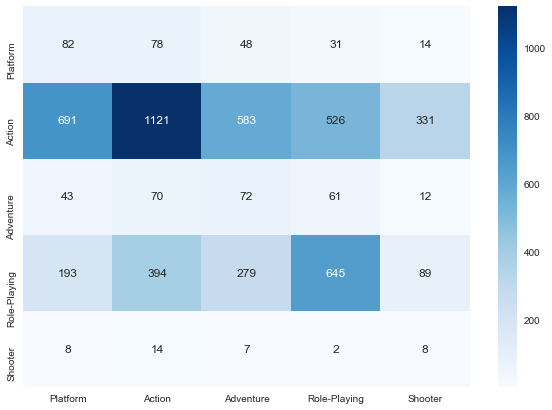

In [19]:
arr = confusion_matrix(clf.predict(X_test), y_test)
df_cm = pd.DataFrame(arr, index = [i for i in y_string],
                  columns = [i for i in y_string])
plt.figure(figsize = (10,7))
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()